In [84]:
# import library functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [65]:
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

In [66]:
df = pd.read_csv (r'C:\Users\e135634\OneDrive - Blue Cross Blue Shield of Michigan\Desktop\Test Folder\heart.csv')

In [67]:
df_dummies = pd.get_dummies(df, columns = ['Sex' , 'ExerciseAngina' , 'ChestPainType' , 'RestingECG' , 'ST_Slope'])
df_dummies = df_dummies.reindex(columns = [col for col in df_dummies.columns if col != 'HeartDisease'] + ['HeartDisease'])

df = df_dummies.astype({"Age" : 'float' , "RestingBP" : 'float' ,"Cholesterol" : 'float' ,"FastingBS" : 'float' ,
                                "MaxHR" : 'float' ,"Sex_F" : 'float' ,"Sex_M" : 'float' ,"ExerciseAngina_N" : 'float' ,
                                "ExerciseAngina_Y" : 'float' ,"ChestPainType_ASY" : 'float' ,"ChestPainType_ATA" : 'float' ,
                                "ChestPainType_NAP" : 'float' ,"ChestPainType_TA" : 'float' ,"RestingECG_LVH" : 'float' ,
                                "RestingECG_Normal" : 'float' ,"RestingECG_ST" : 'float' ,"ST_Slope_Down" : 'float' ,
                                "ST_Slope_Flat" : 'float' ,"ST_Slope_Up" : 'float',"HeartDisease" : 'int'})

df = df[df.Cholesterol > 0]

In [85]:
# Adding a 6-2-2 split of the data into Training, Testing, and Validation Sets to fine tune hyper parameter k
X = df.iloc[:, :-1]
y = df.iloc[: , -1]

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'HeartDisease', 
                                                                            train_size=0.6, valid_size=0.2, test_size=0.2)

In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

In [87]:
# this is the distance metric I will use as a helper function below in the KNN class 

def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [88]:
# this helper function is used in the predict definition below to help distinguish majority vote (most common class label)
# I was unable to figure out how to use the Counter package from eht collections library without causing error

def most_common(lst):
    return max(set(lst), key=lst.count)

In [89]:
class KNN:
    
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy

In [90]:
# fine tune hyper parameter k on validation data for k values 1 - 30 to see which one gives us the best results

accuracies = []
ks = range(1, 30)
for k in ks:
    model = KNN(k=k)
    model.fit(X_valid, y_valid)
    accuracy = model.evaluate(X_test, y_test)
    accuracies.append(accuracy)

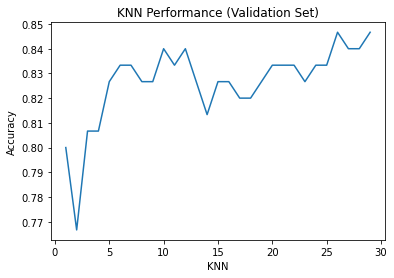

In [91]:
# make a visual plot showing the best k parameter to use based on validation set

fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="KNN",
       ylabel="Accuracy",
       title="KNN Performance (Validation Set)")
plt.show()

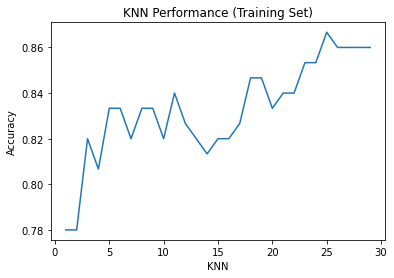

In [92]:
# now, I will take a look at fine tuning hyper parameter K using training set to see if results are the same

accuracies = []
ks = range(1, 30)
for k in ks:
    model = KNN(k=k)
    model.fit(X_train, y_train)
    accuracy = model.evaluate(X_test, y_test)
    accuracies.append(accuracy)
    
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="KNN",
       ylabel="Accuracy",
       title="KNN Performance (Training Set)")
plt.show()

In [93]:
# based on the two separate sets (validation and training), there is a vast difference between
# validation of 21 and training of 7, so I will use both below to to see which one gets me the highest accuracy

In [94]:
# use the best k parameter above to plug into my model belowe for evaluation

k = 21

model = KNN(k = k)
model.fit(X_train , y_train)
predictions = model.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[71 12]
 [12 55]]
0.84
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        83
           1       0.82      0.82      0.82        67

    accuracy                           0.84       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.84      0.84      0.84       150



In [95]:
k = 7

model = KNN(k = k)
model.fit(X_train , y_train)
predictions = model.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

[[67 16]
 [11 56]]
0.82
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        83
           1       0.78      0.84      0.81        67

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



In [96]:
# so based on this, k = 7 gives us the highest accuracy score

In [97]:
# running data through pre-built sklearn function just to see how my formula compares

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 7, metric = "euclidean")
knn.fit(X_train, y_train)
predict = knn.predict(X_test)

print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))
accuracy1 = accuracy_score(y_test, predict)
print("accuracy:" , accuracy1)

[[67 16]
 [11 56]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        83
           1       0.78      0.84      0.81        67

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

accuracy: 0.82


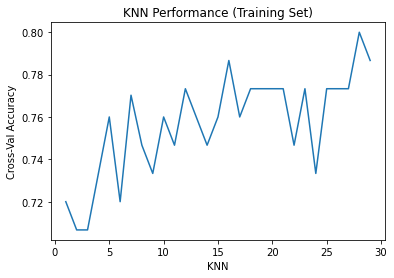

In [104]:
# since I had a wide range between my validation set and training set K's, Im going to do a quick cross validation score
# using the pre-built sklearn function on the entire dataset just to see if the results are different (using 10 fold CV)

cv = 10
accuracies = []
ks = range(1, 30)
for k in ks:
    model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(model , X , y, cv = cv, scoring = "accuracy")
    accuracies.append(scores.max())
    
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="KNN",
       ylabel="Cross-Val Accuracy",
       title="KNN Performance (Training Set)")
plt.show()

In [103]:
# so based on this, optimal K varies across the entire data set and has a lower accuracy overall